# Module 4 Final Project

## Time Series Analysis

Name: Hazel Donaldson <br>
Pace: Part-time <br>
Review Date: <br>
Instructor Name: Victor Geislinger <br>

## 1. Introduction
In this project, I will be performing a time series analysis on historical housing data obtained from Zillow. I will be looking for the top 5 zipcodes a real estate developer should invest in (buy homes, renovate and rent to people). This investor is looking for busy, dense metropolitan areas with average house prices around the median. 

## 2. Libraries and Functions

In [1]:
# import necessary libraries for EDA, visualization and time series analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
import itertools 
import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
plt.style.use('ggplot')
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# add functions here
def melt_data(df): #from Flatiron school
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

def acf_pacf(df, alags=48, plags=48):
    '''Creates the ACF and PACF plots to 
    observe possible parameters for ARIMA model'''
    #Create figure
    fig,(ax1, ax2) = plt.subplots(2,1, figsize=(13,8))
    #Create ACF plot
    plot_acf(df, lags=alags, zero=False, ax=ax1)
    #PACF plot
    plot_pacf(df, lags=plags, ax=ax2)
    plt.show()
    
def seasonal_plot(df, N=13, lags=[12,24,36,48,60,72]):
    #differencing the rolling mean to find seasonality in acf plot
    fig,(ax1, ax2) = plt.subplots(2,1,figsize=(13,8))
    rolling = TS_80631 - TS_80631.rolling(N).mean()
    plot_acf(rolling.dropna(), lags=lags, ax=ax1)
    plot_pacf(rolling.dropna(), lags=lags, ax=ax2)
    plt.show();

def train_test(df):
    #Set training data before 2015
    train = df[:'2015-04']
    #Set test data starting 2015
    test = df['2015-05':]
    return train, test
  

def model_fit(df, pdq=(1,0,1), pdqs=(0,0,0,1)):
    train, test = train_test(df)
    model = SARIMAX(train, order= pdq, seasonal=pdqs)
    results = model.fit()
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show()
    return train, test, results

        
def forecast(df, pred_date, start_date):
    #make these global so they can be accessed later
    global pred
    global pred_conf
    
    #get predictions from specific date and calculate confidence intervals
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    
    #plot real vs predicted values
    rcParams['figure.figsize'] = 15,6
    
    #plot observed values
    ax = df[start_date:].plot(label='Observed')
    
    #plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-Step Forecast', alpha=.9)
    
    #plot range of confidence intervals
    ax.fill_between(pred_ci.index,
                   pred_ci.iloc[:,0],
                   pred_ci.iloc[:, 1], color = 'g', alpha=.5)
    #axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Monthly Returns')
    plt.legend()
    
    plt.show() 

def dynamic_forecast(zipcode, pred_date, start_date):
    #make variables global so they can be used outside of function
    global pred_dynamic
    global pred_dynamic_ci
    
    #get predictions from specific dates and calculate confidence intervals
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    
    #plot dynamic forecast and confidence intervals
    ax = zipcode[start_date:].plot(label='Observed', figsize=(20,15))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
    
    ax.fill_between(pred_dynamic_ci.index,
                   pred_dynamic_ci.iloc[:, 0],
                   pred_dynamic_ci.iloc[:, 1], color='g', alpha=.3)
    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(start_date), zipcode_forecasted.index[-1], alpha=.1, zorder=-1)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Monthly Returns')
    plt.legend()
    plt.show()
        
def future_forecast_model(df, pdq=(1,0,1), pdqs=(0,0,0,1), display=True, zc='input zipcode'):
    '''Forecast time series data up to 10-years. outputs monthly
    returns after 1yr, 3yrs, 5yrs and 10yrs for each zipcode'''
    model = SARIMAX(df, order=pdq, seasonal_order=pdqs)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04', end='2028-04', dynamic=True)
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:, 1],
                       color= 'k', alpha=.25, label='Confidence Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_3=(1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    year_10=(1+output.predicted_mean).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    tot_ret = [zc,year_1,year_3,year_5,year_10]
    return tot_ret

## 3. Import dataset

In [3]:
zillow_df = pd.read_csv('zillow_data.csv')
print(zillow_df.info(), '\n')
print(f'Unique amount of zipcodes: {zillow_df.RegionName.nunique()}')
zillow_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB
None 

Unique amount of zipcodes: 14723


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
zillow_df.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,14723.000000,14723.000000,14723.000000,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,...,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04
mean,81075.010052,48222.348706,7362.000000,1.182991e+05,1.184190e+05,1.185374e+05,1.186531e+05,1.187803e+05,1.189275e+05,1.191205e+05,...,2.733354e+05,2.748658e+05,2.764646e+05,2.780332e+05,2.795209e+05,2.810953e+05,2.826571e+05,2.843687e+05,2.865114e+05,2.880399e+05
std,31934.118525,29359.325439,4250.308342,8.600251e+04,8.615567e+04,8.630923e+04,8.646795e+04,8.665094e+04,8.687208e+04,8.715185e+04,...,3.603984e+05,3.614678e+05,3.627563e+05,3.644610e+05,3.656003e+05,3.670454e+05,3.695727e+05,3.717739e+05,3.724612e+05,3.720544e+05
min,58196.000000,1001.000000,1.000000,1.130000e+04,1.150000e+04,1.160000e+04,1.180000e+04,1.180000e+04,1.200000e+04,1.210000e+04,...,1.440000e+04,1.450000e+04,1.470000e+04,1.480000e+04,1.450000e+04,1.430000e+04,1.410000e+04,1.390000e+04,1.380000e+04,1.380000e+04
25%,67174.500000,22101.500000,3681.500000,6.880000e+04,6.890000e+04,6.910000e+04,6.920000e+04,6.937500e+04,6.950000e+04,6.960000e+04,...,1.269000e+05,1.275000e+05,1.282000e+05,1.287000e+05,1.292500e+05,1.299000e+05,1.306000e+05,1.310500e+05,1.319500e+05,1.324000e+05
50%,78007.000000,46106.000000,7362.000000,9.950000e+04,9.950000e+04,9.970000e+04,9.970000e+04,9.980000e+04,9.990000e+04,9.995000e+04,...,1.884000e+05,1.896000e+05,1.905000e+05,1.914000e+05,1.925000e+05,1.934000e+05,1.941000e+05,1.950000e+05,1.967000e+05,1.981000e+05
75%,90920.500000,75205.500000,11042.500000,1.432000e+05,1.433000e+05,1.432250e+05,1.432250e+05,1.435000e+05,1.437000e+05,1.439000e+05,...,3.050000e+05,3.066500e+05,3.085000e+05,3.098000e+05,3.117000e+05,3.134000e+05,3.151000e+05,3.168500e+05,3.188500e+05,3.211000e+05
max,753844.000000,99901.000000,14723.000000,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,...,1.888990e+07,1.870350e+07,1.860530e+07,1.856940e+07,1.842880e+07,1.830710e+07,1.836590e+07,1.853040e+07,1.833770e+07,1.789490e+07


Looking at our data set, I can see that it is provided in wide-format. Further down, I will transform the data set into long format so that it is easier to read. There are 14,723 unique zipcodes in the data, so the next step will be to select the zipcodes that fit the investor's interests.

## 4. Data Preprocessing

In [5]:
# Find the zipcodes that are in highly urbanized areas
print(zillow_df.SizeRank.describe())
#Calculate 20% cutoff point
srank_20 = zillow_df.SizeRank.quantile(q=0.20)
print(f'Size Rank 20% cutoff value: {srank_20}')
#New dataframe
top_20_zc = zillow_df[zillow_df['SizeRank'] < srank_20].drop(['RegionID','City','State','Metro','CountyName','SizeRank'],axis=1)
print(f'Amount of zipcodes: {len(top_20_zc)}')

count    14723.000000
mean      7362.000000
std       4250.308342
min          1.000000
25%       3681.500000
50%       7362.000000
75%      11042.500000
max      14723.000000
Name: SizeRank, dtype: float64
Size Rank 20% cutoff value: 2945.4
Amount of zipcodes: 2945


The number of zipcodes has been narrowed down to 2,945 from 14,723. Now I will narrow down the zipcodes to housing prices that hover around the median price. The average value will be calculated from last year's data as this the data the investor is mostly likely to encounter.

In [6]:
top_20_zc['yr_avg'] = top_20_zc.iloc[:,-12:].mean(skipna=True, axis=1)
print(top_20_zc['yr_avg'].describe())
q_60 = top_20_zc['yr_avg'].quantile(q=0.60)
q_35 = top_20_zc['yr_avg'].quantile(q=0.35)
print(f'Average Value for 60% cutoff rate: {round(q_60, 2)}')
print(f'Average Value for 35% cutoff rate: {round(q_35, 2)}')
pref_zc = top_20_zc[(top_20_zc['yr_avg'] < q_60) & (top_20_zc['yr_avg'] > q_35)]
print(f'Amount of zipcodes: {len(pref_zc)}')

count    2.945000e+03
mean     3.730666e+05
std      5.836511e+05
min      3.632500e+04
25%      1.691333e+05
50%      2.484083e+05
75%      3.978333e+05
max      1.858138e+07
Name: yr_avg, dtype: float64
Average Value for 60% cutoff rate: 290211.67
Average Value for 35% cutoff rate: 198641.67
Amount of zipcodes: 736


The number of zipcodes to consider is now 736. This takes in some of the requirements the investor is looking for: urbanization and median home value. Now, its time to look at things from an investment standpoint and calculate the return on investment and the coefficient of variance to take into account the risks involved. The return on investment or ROI is percentage increase in price. I will be calculating the ROI  between 2013-2018. This will represent the areas with the highest recent price uptrend. 

On the other hand, the investor will want to select areas where there is low volatility. It lowers risks when housing prices drop. The coefficient of variance is also used here, it's defined by the standard deviation divided by the mean. All 22 years of data is used here and null values are skipped. The higher the coefficient, the more volatile the zipcode.

In [7]:
pref_zc['roi'] = (pref_zc['2018-04']- pref_zc['2013-01'])/pref_zc['2013-01']
#calculate the standard deviation of monthly values between 1996 to 2018
pref_zc['std'] = pref_zc.loc[:,'1996-04': '2018-04'].std(skipna=True, axis=1)
#calculate historic mean
pref_zc['mean'] = pref_zc.loc[:, '1996-04': '2018-04'].mean(skipna=True, axis=1)
#calculate the coefficient of variance
pref_zc['CV'] = pref_zc['std']/pref_zc['mean']
#show calculated values
pref_zc[['RegionName', 'std', 'roi', 'CV']].head(10)

,RegionName,std,roi,CV
11,32162,53805.394161,0.227694,0.292910
14,37013,19771.938500,0.696557,0.142048
17,37211,36496.608464,0.798502,0.247623
18,78660,24894.592870,0.437537,0.148012
22,77573,29647.359699,0.412973,0.161776
23,77584,27064.756641,0.378291,0.143482
31,78130,23349.861603,0.410077,0.152247
38,77429,25209.719327,0.397936,0.141715
45,77433,28113.378077,0.335095,0.148727
51,30043,24035.181933,0.648415,0.142436


In [8]:
#descriptive statistics for coefficient of variance
print(pref_zc['CV'].describe())
#define an upper limit for CV
upper_cv = pref_zc.CV.quantile(q=0.60)
print(f'Upper CV limit: {upper_cv}')
#get zipcodes with highest ROIs within risk profile
best_zc = pref_zc[pref_zc.CV < upper_cv].sort_values('roi', ascending=False, axis=0)[:5]
best_zc[['RegionName', 'roi', 'CV']].head(20)

count    736.000000
mean       0.238700
std        0.080020
min        0.056119
25%        0.171094
50%        0.226459
75%        0.291877
max        0.453303
Name: CV, dtype: float64
Upper CV limit: 0.25459687610566145


,RegionName,roi,CV
1235,80631,1.037433,0.239795
2419,97233,0.983516,0.248805
422,78758,0.898876,0.228653
2693,98444,0.832353,0.244243
2005,37214,0.811351,0.216641


In [9]:
#get location names
best_zipcodes = list(best_zc.RegionName.values)
for i in best_zipcodes:
    city = zillow_df[zillow_df['RegionName']== i].City.values[0]
    state = zillow_df[zillow_df['RegionName'] == i].State.values[0]
    print(f'Zipcode: {i}\n Location: {city}, {state}\n')

Zipcode: 80631
 Location: Greeley, CO

Zipcode: 97233
 Location: Portland, OR

Zipcode: 78758
 Location: Austin, TX

Zipcode: 98444
 Location: Parkland, WA

Zipcode: 37214
 Location: Nashville, TN



The data is still formatted in a wide format, with each month as a column. In order to perform a time series analysis, it needs to be formatted in long format, with month as a row.

In [10]:
TS_ZC5 = best_zc.drop(['yr_avg', 'std', 'mean', 'roi', 'CV'], axis=1)
TS_ZC5 =melt_data(TS_ZC5).set_index('time')
print('Time Series Data for top 5 zipcodes:\n', TS_ZC5.head())
dfs_ts = []
for zc in TS_ZC5.RegionName.unique():
    df = TS_ZC5[TS_ZC5['RegionName']==zc].asfreq('MS')
    dfs_ts.append(df)
dfs_ts[0].head()

Time Series Data for top 5 zipcodes:
             RegionName     value
time                            
1996-04-01       80631   86500.0
1996-04-01       97233  110800.0
1996-04-01       78758  129000.0
1996-04-01       98444  100400.0
1996-04-01       37214   88300.0


,RegionName,value
time,,
1996-04-01,80631,86500.0
1996-05-01,80631,87000.0
1996-06-01,80631,87500.0
1996-07-01,80631,87900.0
1996-08-01,80631,88400.0


## EDA and Visualization

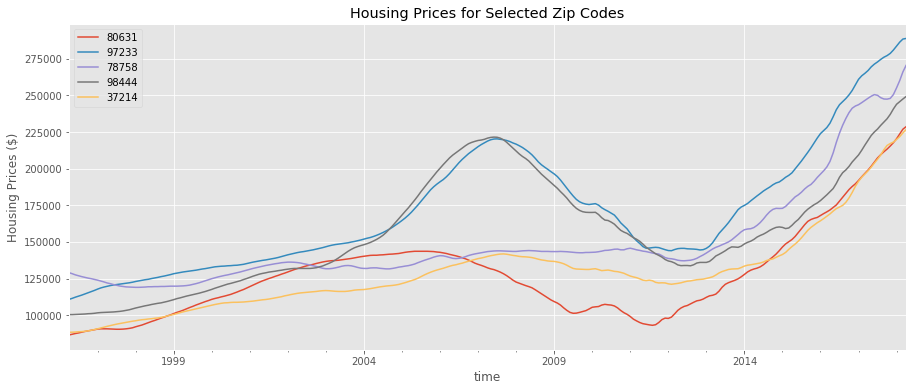

In [11]:
for i in range(5):
    dfs_ts[i].value.plot(label=dfs_ts[i].RegionName[0], figsize=(15,6))
    plt.title('Housing Prices for Selected Zip Codes')
    plt.ylabel('Housing Prices ($)')
    plt.legend()

The graph above shows the prices are about the same for the 22 year period and I can see that the housing trends for Portland (97233) and Parkland(98444) got higher and fell around the time of the great housing crash and recession of 2009. There is a bit of the a dip in the Greeley(80631) trend around the time of the housing crash. 

In [12]:
for i in range(len(dfs_ts)):
    print(f'Value descriptive statistics for zipcode {dfs_ts[i].RegionName[0]}:')
    print(f'{dfs_ts[i].value.describe()}\n')

Value descriptive statistics for zipcode 80631:
count       265.000000
mean     127692.075472
std       30619.962378
min       86500.000000
25%      105000.000000
50%      123900.000000
75%      140900.000000
max      228600.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 97233:
count       265.000000
mean     171571.698113
std       42687.913348
min      110800.000000
25%      139400.000000
50%      158900.000000
75%      199100.000000
max      288800.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 78758:
count       265.000000
mean     149549.056604
std       34194.863952
min      119000.000000
25%      131900.000000
50%      139900.000000
75%      145000.000000
max      270400.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 98444:
count       265.000000
mean     157524.528302
std       38474.187065
min      100400.000000
25%      130400.000000
50%      150600.000000
75%      186400.000000
max     

Since most of the prices in the housing trend graph above are similar, we will need a better way to compare the zipcodes. We will look at the monthly returns because the returns are comparable to each other and prices are dependent to the previous price. The returns are more likely to be stationary and have a constant mean of zero.

In [13]:
# new column for monthly returns
for zc in range(len(dfs_ts)):
    dfs_ts[zc]['ret'] = np.nan *len(dfs_ts)
    for i in range(len(dfs_ts[zc])-1):
        dfs_ts[zc]['ret'][i+1] = (dfs_ts[zc].value.iloc[i+1]/dfs_ts[zc].value.iloc[i]) - 1

Before we can begin modeling, an important assumption needs to be confirmed: stationary. Stationary tells us that the mean is constant, the standard deviation is constant and there is not seasonality.

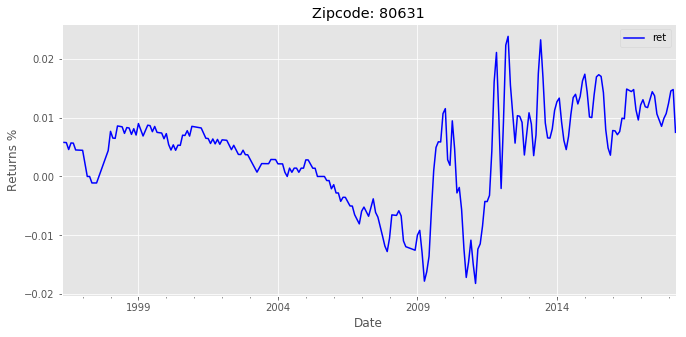

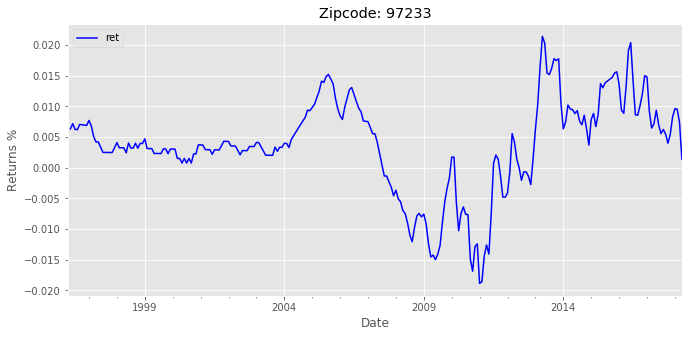

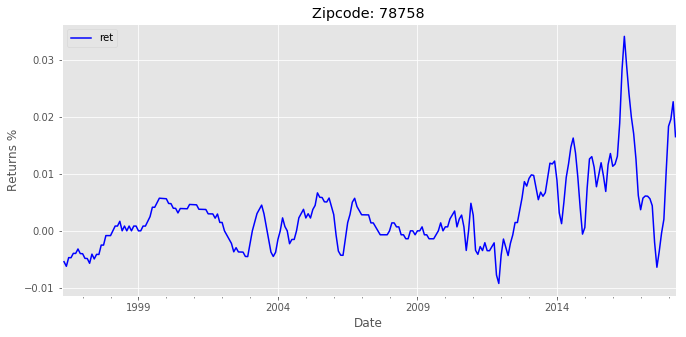

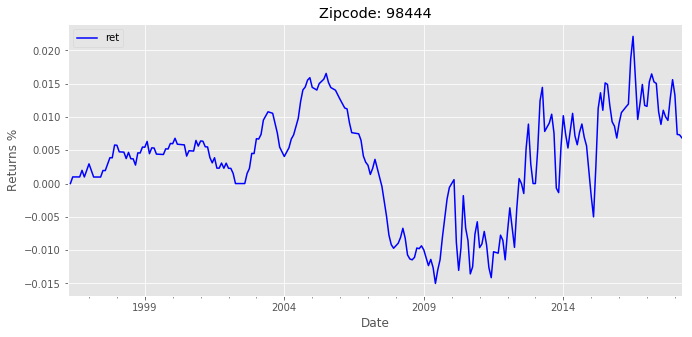

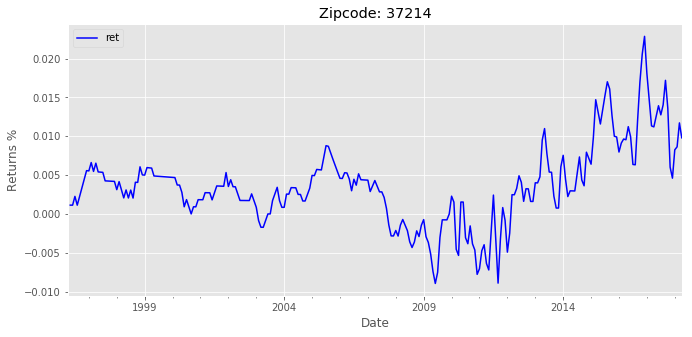

In [14]:
#plot the monthly returns for each zipcode
for i in range(len(dfs_ts)):
    dfs_ts[i].ret.plot(figsize=(11, 5), color = 'b')
    plt.title(f'Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns %')
    plt.legend(loc='best')
    plt.show()

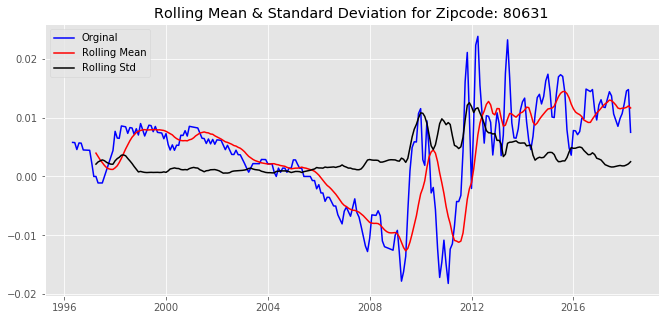

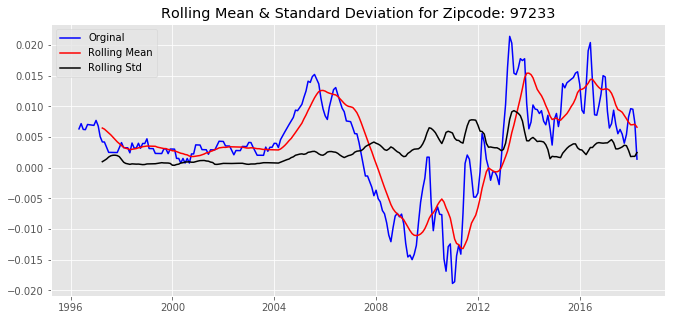

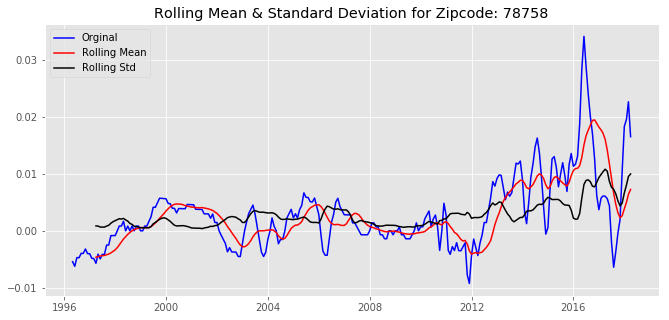

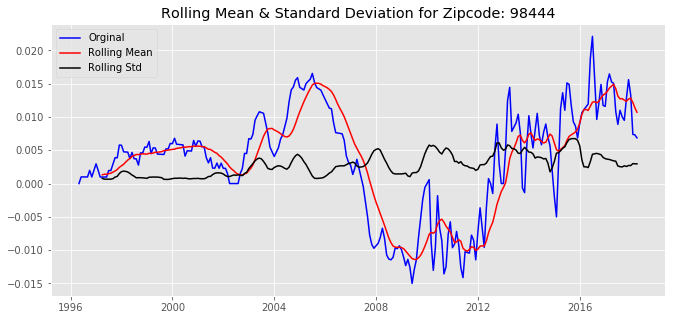

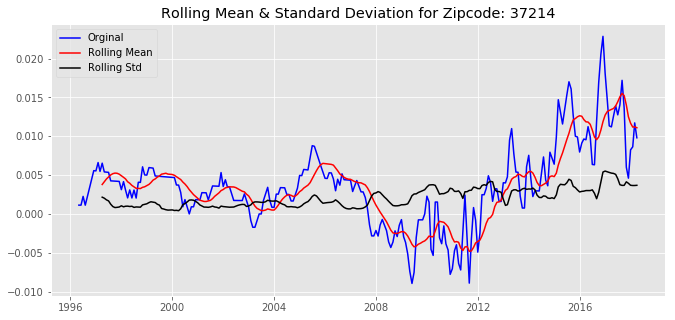

In [15]:
for i in range(len(dfs_ts)):
    rolmean= dfs_ts[i].ret.rolling(window=12, center=False).mean()
    rolstd = dfs_ts[i].ret.rolling(window=12, center=False).std()
    fig = plt.figure(figsize=(11, 5))
    orig = plt.plot(dfs_ts[i].ret,color='blue',label='Orginal')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.show()

Visually, the data seems to not be stationary. However, we will challenge this visualizations using the Dickey-Fuller test and confirm whether or not the data is truly stationary. The Dickey-Fuller test is a statistical test of stationary in a time series. The null hypothesis of the Dickey-Fuller test say that the data is not stationary and the alternative hypothesis says the data is stationary. We will set the confidence level to 95% and we will reject the null hypothesis if there is p-value greater than 0.05.

In [16]:
for i in range(5):
    results = adfuller(dfs_ts[i].ret.dropna())
    print(f'ADFuller test p-value for stationary: {dfs_ts[i].RegionName[0]}')
    print('P-value',results[1])
    if results[1] > 0.05:
        print('Fail to reject the null hypothesis. The data is not stationary.\n')
    else:
        print('Reject the null hypothesis. The data is stationary.\n')

ADFuller test p-value for stationary: 80631
P-value 0.710539628008088
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 97233
P-value 0.11396395166248763
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 78758
P-value 0.17369935135771158
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 98444
P-value 0.3107084009520179
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 37214
P-value 0.5467030124705775
Fail to reject the null hypothesis. The data is not stationary.



As we can see above, none of the zipcodes are stationary and will need to take the first difference to see the effect on stationary.

In [17]:
#take the first order of intergration
for i in range(5):
    results = adfuller(dfs_ts[i].ret.diff().dropna())
    print(f'ADFuller test p-value for stationary: {dfs_ts[i].RegionName[0]}')
    print('P-value',results[1])
    if results[1] > 0.05:
        print('Fail to reject the null hypothesis. The data is not stationary.\n')
    else:
        print('Reject the null hypothesis. The data is stationary.\n')

ADFuller test p-value for stationary: 80631
P-value 6.064327655106482e-10
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 97233
P-value 4.884612558355817e-08
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 78758
P-value 8.497498344953488e-09
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 98444
P-value 0.0006377881980377828
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 37214
P-value 2.7102862556018217e-07
Reject the null hypothesis. The data is stationary.



By taking the first difference of the data, all the data is now stationary. Moving forward, the I or integration for the ARIMA or SAMIRA model will be one. 

In [18]:
#create individual times series for each zipcode
TS_80631 = dfs_ts[0].ret.dropna() #zipcode 80631 monthly returns time series
TS_80631d = dfs_ts[0].ret.diff().dropna() # differenced time series

TS_97233 = dfs_ts[1].ret.dropna()
TS_97233d = dfs_ts[1].ret.diff().dropna()

TS_78758 = dfs_ts[2].ret.dropna()
TS_78758d = dfs_ts[2].ret.diff().dropna()

TS_98444 = dfs_ts[3].ret.dropna()
TS_98444d = dfs_ts[3].ret.diff().dropna()

TS_37214 = dfs_ts[4].ret.dropna()
TS_37214d = dfs_ts[4].ret.diff().dropna()

## Time Series Modeling

## Zipcode: 80631 (Greeley, CO)

To begin, I will plot the ACF and PACF to find the p and q parameter of this zipcode's ARIMA model. We have previously found the 'I' parameter to be 1 when we took the first difference.

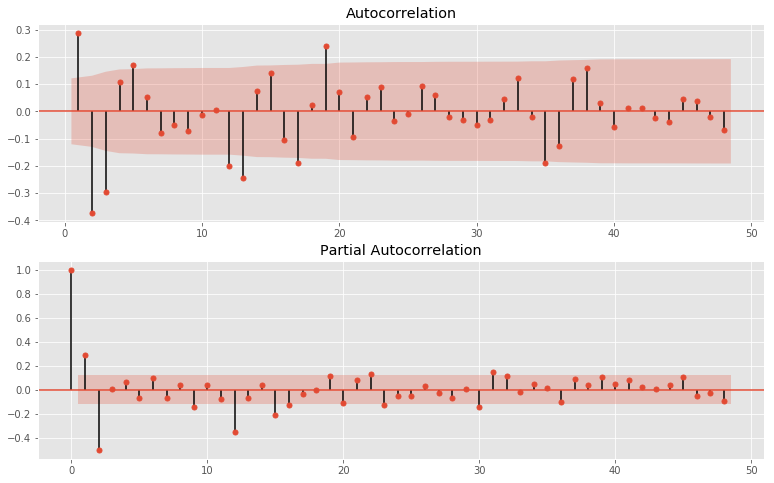

In [19]:
acf_pacf(TS_80631d)

From the plots, we can see that the ACF has 1 positive lag and two negative lags that are statistically significant so the MA(q) parameter is 1. The AR(p) is 2 or 3. Now, let's check for seasonality in the returns.

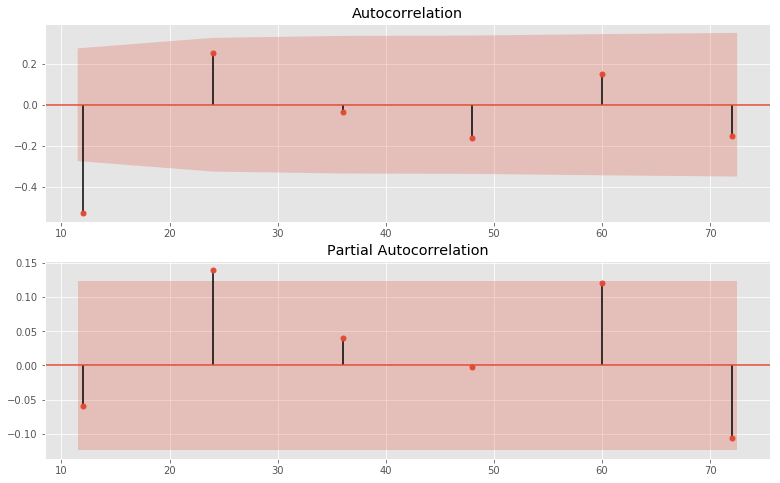

In [20]:
seasonal_plot(TS_80631d, N=13)

As we can see, there is a statistically significant lag at 12 in the autocorrelation plot and a slight statistically significant lag at 24 months in the partial autocorrelation plot which lends credence to the fact that there is seasonality in the data. So, we can move forward with seasonal ARIMA model or SARIMA model. The ARIMA model is the most common method in time series analysis, which stands for Auto-Regressive Integrated Moving Average.

The ARIMA model has three components: AR (auto-regression, the p-value) component allows us to incorporate the effect of past values on our model. For example, the price of flowers may be high because the price of flowers has been high for the past few months. The AR terms are lags of the dependent variable. For instance, if p is 5, the predictors of x(t) will be x(t-1)...x(t-5). 
Number of differences of integration (d-value) is the value of the amount of differencing as it identifies the number of lags to subtract from the current observations. This is similar to saying that price of flowers is likely to be high because the difference in the price of flowers in the last couple of months was small. 
The MA(moving average: q-value) component of the model is a linear combination of error values observed at different points in the past. For instance if the q-value in a model is 2, then x(t)'s predictors are e(t-1) and e(t-2). The term s is the periodicity of the time series(4 is quarterly periods and 12 is annual periods).

In [ ]:
#Use auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(TS_80631,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

The AIC value or Akaike Information Criterion provided by the statsmodels library. AIC is an estimator of the relative quality of the statistical model of a given data set and provides a mean of model selection. A model with many features that fits the data well will be assigned a larger AIC value than a model with fewer features to acheive the same goodness of fit. Therefore, we are interested in a lowest AIC value possible.

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_80631,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
# Find the parameters with minimal AIC value.

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Hazel\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

From the code above, we see our ARIMA parameters are p = 1, q=1 and P = 1, Q = 1. From previous AD Fuller tests, we found that the data wasn't stationary and therefore the 'I' in the SARIMA model is one. Let's proceed to see if these paramaters fit our model.

In [ ]:
#Fit parameters for ARIMA model
pdq = (1,1,1)
pdqs = (1,1,1,12)
model_fit(TS_80631, pdq, pdqs)

 From the above plots, we can see that the KDE curve is relatively close to the N(0,1) curve which indicates that the residuals are normally distributed. The Q-Q plot also shows us that the residuals are normally distributed because the blue dots(the residuals) are along the red line(normal distribution). The graph at the top left, doesn't show any obvious seasonality and appears to be white noise.This is confirmed with the graph at the bottom right because the time series residuals have a low correlation with lagged verisons of themselves.

## Validating Model

The next step after fitting the model is to validate the model by comparing the predicted value to real values to the accuracy of our model.

In [ ]:
forecast(TS_80631,'2018-01-01', '2005-01-01')

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In [ ]:
ax = TS_80631['2010':].plot(lw=5)
pred.predicted_mean(ax=ax, label='One-step Forecast', alpha=.7, lw=5)
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
ax.legend(['Observed', 'One-step Forecast'])

As we can see from the graph above, the one step forecast seems to align with the true values very well. It will also be useful to quantity the accuracy of our forecasts. We will use the MSE or mean squared error, which summarizes the average error of our forecasts. 

In [ ]:
zipcode_forecasted = pred.predicted_mean
zipcode_truth = TS_80631['2015-01-01':]
mse = ((zipcode_forecasted-zipcode_truth)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(mse, 2))

The mean squared error of our one step ahead forecasts yielded a value of 6.40e-6, which is a very low as it is close to zero. This tells use that our predictions are very close to the actual observations. However a better representation of the predictive power of our model can be obtained using dynamic forecasts.

## Dynamic Forecast

With dynamic forecasting we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In [ ]:
dynamic_forecast(TS_80631, '2013-01-01', '2005-01-01')

From the graph above, the dynamic forecast doesn't seem to align as well as the previous forecast. As with the previous forecast, we will check the accuracy of the model.

In [ ]:
def dynamic_mse_score(zipcode, pred_date):

    zipcode_forecasted = pred_dynamic.predicted_mean
    zipcode_truth = zipcode[pred_date:][:]

    #compute mean square error
    mse_score = ((zipcode_forecasted - zipcode_truth) ** 2).mean()
    print('The mean squared error of our forecast is {}'.format((mse_score),2))

In [ ]:
dynamic_mse_score(TS_80631, '2013-01-01')

The predicted values obtained from the dynamic forecast is 1.67e-5 which is slightly smaller than the one step forecast. Both the one step forecast and the dynamic forecast confirm that our time series is value. To complete this zipcode's time series analysis, we will predict up to the 10 year monthly returns.

In [ ]:
ret_80631 = future_forecast_model(TS_80631, pdq=pdq, pdqs=pdqs, zc = 80631)

## Zipcode 97233(Portland, OR)

Like the previous data, the data was not stationary so the plots for the ACF and PACF will be done with differenced data. The 'I' in the model will also be one.

In [ ]:
acf_pacf(TS_97233d)

From these plots, we can see the lags are tailing off and there will be AR & MA parameters in our model.

In [ ]:
seasonal_plot(TS_97233d, N=13)

We can see that there is only one statistically significant lag at 12 months but this doesn't seem to be repeated at other 12 month intervals so it is possible there is no seasonality in the data.

In [ ]:
results = pm.auto_arima(TS_97233, information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_97233,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
# Find the parameters with minimal AIC value.

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

From the following SARIMA model parameters are: p = 1, d = 1, q = 1; P = 1, Q = 1. Let's proceed with fit these parameters to the model.

In [ ]:
# fit SARIMA model
pdq = (1,1,1)
pdqs = (1,1,1,12)
train, test, results = model_fit(TS_97233, pdq=pdq, pdqs=pdqs)

From above, we can see that the KDE plot fits the N(0,1) closely and the the residuals on the the Q-Q plot closely follows that normally distributed line which tells us that the residuals are probably normally distributed. The standardized residual plot looks like mostly white noise and the autocorrelation plot shows us that the residuals are not closely related to lagged verisons of themselves. Now, we can validate our forecast.

In [ ]:
forecast(TS_97233, '2013-01-01', '2005-01-01')

In [ ]:
zipcode_forecasted = pred.predicted_mean
zipcode_truth = TS_97233['2013-01-01':]
mse = ((zipcode_forecasted-zipcode_truth)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(mse, 2))

In [ ]:
dynamic_forecast(TS_97233, '2013-01-01', '2005-01-01')

In [ ]:
dynamic_mse_score(TS_97233, '2013-01-01')

In [ ]:
ret_97233 = future_forecast_model(TS_97233, pdq=pdq, pdqs=pdqs, zc = 97233)

## Zipcode 78758(Austin, TX)

Similar to the other monthly returns, because the data was not stationary we will use the differenced data in the ACF & PACF plots.

In [ ]:
acf_pacf(TS_78758d)

From the plots, there is some statistically significant lags for the MA(q) at 6 and the AR(p) at 3 or 4. Now, we will check for seasonality.

In [ ]:
seasonal_plot(TS_78758d, N=13)

While there is a statistically significant lag at 12 months, there are no other significant lags at other 12 month intervals, so it is probable that there is no seasonality in the data. Now, we will find the parameter for the model.

In [ ]:
results = pm.auto_arima(TS_78758, information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_78758,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
# Find the parameters with minimal AIC value.

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

The model parameters are: p = 1, d = 1, q = 1; P = 1, D = 0, Q = 0. 

In [ ]:
# fit SARIMA model
pdq = (1,1,1)
pdqs = (0,0,0,12)
train, test, results = model_fit(TS_78758, pdq=pdq, pdqs=pdqs)

One of the coefficients is not statistically significant but we can see the residuals are mostly normal with the tails in the Q-Q plot taper off. The standardized residuals also shows some white noise. 

In [ ]:
forecast(TS_78758, '2013-01-01', '2005-01-01')

In [ ]:
zipcode_forecasted = pred.predicted_mean
zipcode_truth = TS_78758['2013-01-01':]
mse = ((zipcode_forecasted-zipcode_truth)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(mse, 2))

In [ ]:
dynamic_forecast(TS_78758, '2013-01-01', '2005-01-01')

In [ ]:
dynamic_mse_score(TS_78758, '2013-01-01')

In [ ]:
ret_78758 = future_forecast_model(TS_78758, pdq=pdq, pdqs=pdqs, zc = 78758)

## Zipcode 98444(Parkland, WA)

We will start analyzing this zipcode with differenced data due to it being non-stationary.

In [ ]:
acf_pacf(TS_98444d)

In [ ]:
seasonal_plot(TS_98444d, N=13)

In [ ]:
results = auto_arima(TS_98444, information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_98444,
                                            order=comb,
                                            seasonal_order=combs,
                                            simple_differencing=True,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
# Find the parameters with minimal AIC value.

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
pdq = (1,1,1)
pdqs = (0,0,0,12)
train, test, results = model_fit(TS_98444, pdq=pdq, pdqs=pdqs)

In [ ]:
forecast(TS_98444, '2013-01-01', '2005-01-01')

In [ ]:
zipcode_forecasted = pred.predicted_mean
zipcode_truth = TS_78758['2013-01-01':]
mse = ((zipcode_forecasted-zipcode_truth)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(mse, 2))

In [ ]:
dynamic_forecast(TS_78758, '2013-01-01', '2005-01-01')

In [ ]:
dynamic_mse_score(TS_78758, '2013-01-01')

In [ ]:
ret_98444 = future_forecast_model(TS_98444, pdq=pdq, pdqs=pdqs, zc = 98444)

## Zipcode 37214(Nashville, TN)

In [ ]:
acf_pacf(TS_37214d)

In [ ]:
seasonal_plot(TS_37214d, N=13)

In [ ]:
results = auto_arima(TS_37214, information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_37214,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
# Find the parameters with minimal AIC value.

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
pdq = (1,1,1)
pdqs = (0,0,0,12)
train, test, results = model_fit(TS_37214, pdq=pdq, pdqs=pdqs)

In [ ]:
forecast(TS_37214, '2013-01-01', '2005-01-01')

In [ ]:
zipcode_forecasted = pred.predicted_mean
zipcode_truth = TS_37214['2013-01-01':]
mse = ((zipcode_forecasted-zipcode_truth)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(mse, 2))

In [ ]:
dynamic_forecast(TS_37214, '2013-01-01', '2005-01-01')

In [ ]:
dynamic_mse_score(TS_37214, '2013-01-01')

In [ ]:
ret_37214 = future_forecast_model(TS_37214, pdq=pdq, pdqs=pdqs, zc = 37214)

## Findings

After performing time series analyses on the five zipcodes and forecasting the returns up to ten years, I would recommend the real estate investment company to invest in the top three zipcodes:
1. 78758(Austin, TX) <br>
2. 98444(Parkland, WA) <br>
3. 80631 (Greeley, CO) <br>

The other two zipcodes do not have as high returns as the top three.

In [ ]:
# put the future returns in a dataframe
tot_returns = [ret_37214, ret_98444, ret_78758, ret_80631, ret_97233]
tot_returns = pd.DataFrame(tot_returns, columns=['ZipCode', '1-year', '3-year', '5-year', '10-year'])
tot_returns.sort_values('10-year', ascending=False)

These forecasts are based on historic monthly returns, and past performance does not necessarily predict future results. In the end, if investors are looking for more short-term(1-3 years) investments zipcode 78758 would be the best choice. However if investors are looking for more long-term properties, zipcode 80631 is the best choice. Overall, 80631 is the best choice as it has some of the highest monthly returns out of all the other zipcodes.

# Future Work

These models can be improved by taking other external varaibles into account. These other variables can include tax rates, crime rates, school district ratings and interest rates.
It may to interesting to compare a time series analysis on just housing prices and the monthly returns discovered in this analysis. The results from both would improve the decision making process.